In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

In [5]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

In [36]:
times= [30, 54] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.0, 0.0, 0.0

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # between first and second time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [43]:
beta  = 0.01896278      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
gE = 1/4
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:2]=5; Is_0[2:4]=15; 
Is_0[4:8]=67;  Is_0[7]+=1
Is_0[8:10]=126
Is_0[10:12]=80
Is_0[12:14]=25
Is_0[14]=21
Is_0[15]=3


Ia_0 = np.zeros((M));  Ia_0[4:8]=0; Ia_0[8:11]=0
E_0 = np.zeros((M));  E_0[2:14]=2
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa, 'gE':gE, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SEIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=54;  Nf=700 
data=model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
Is_0

array([  5.,   5.,  15.,  15.,  67.,  67.,  67.,  68., 126., 126.,  80.,
        80.,  25.,  25.,  21.,   3.])

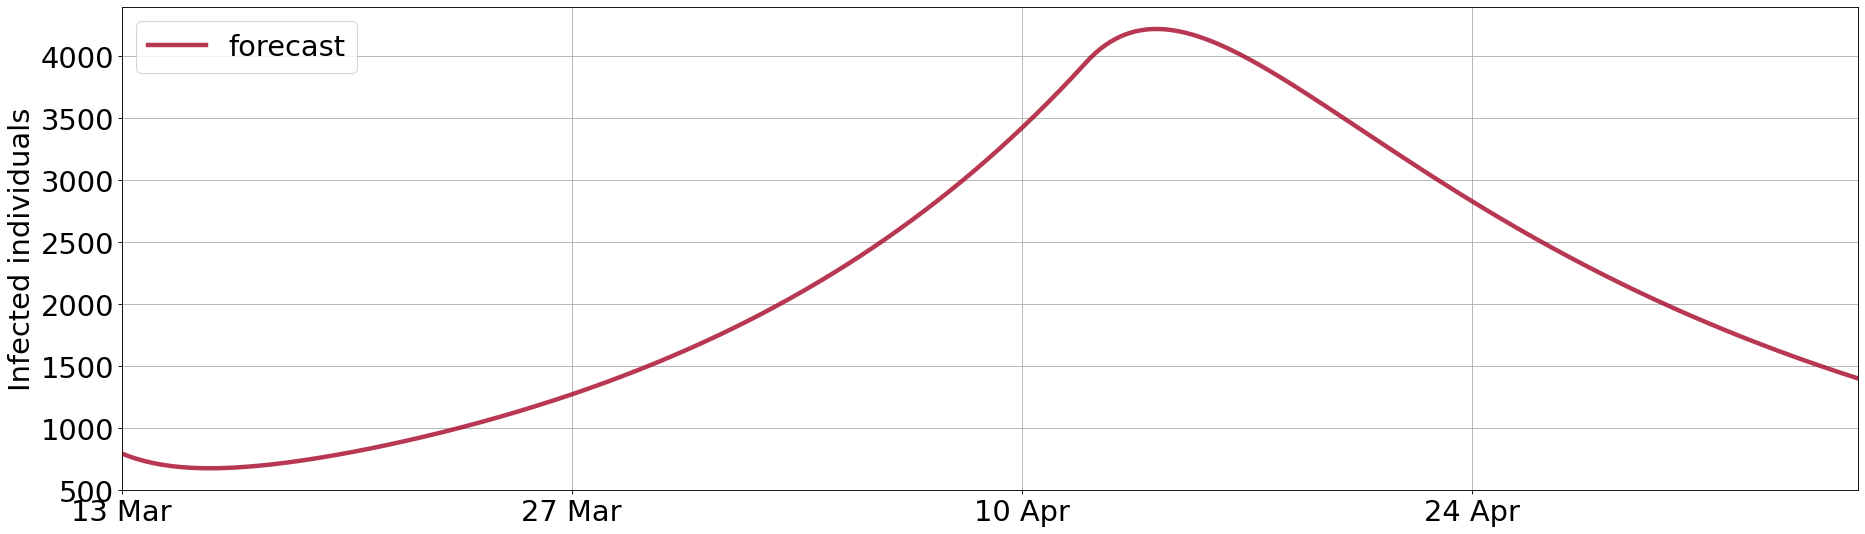

In [46]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,3*M+i] 
t = data['t']; t1=int(Nf/(10))

fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('13 Mar','27 Mar','10 Apr','24 Apr','8 May'));
#plt.fill_between(t[110:], 0, 6000, color="#A60628", alpha=0.2)



my_data = np.genfromtxt('../data/covid-cases/denmark.txt', delimiter='', skip_header=15)
#cases =  my_data[:,2]-my_data[:,3]-my_data[:,4]
day = range(cases.size)
#plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals');
#plt.ylim(0, 600); plt.xlim(0, Tf);